# Load Datasets

In [45]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [47]:
import os

def get_data_path(slug_name):
    base1 = f"/kaggle/input/{slug_name}"
    base2 = "/kaggle/input"
    if os.path.exists(base1):
        return base1
    elif os.path.exists(base2):
        return base2
    else:
        return "./Data"

data_dir = get_data_path("hotel-booking-analysis")

users = pd.read_csv(f"{data_dir}/users.csv")
hotels = pd.read_csv(f"{data_dir}/hotels.csv")
reviews = pd.read_csv(f"{data_dir}/reviews.csv")

# Data Cleaning

In [48]:
def clean_data(hotels, reviews, users):
    # merge all datasets
    tmp_df = pd.merge(hotels, reviews, on='hotel_id')
    df = pd.merge(tmp_df, users, on='user_id')
    
    # rename columns
    df.rename(columns={'country_x': 'hotel_country', 'country_y': 'user_country'}, inplace=True)

    # convert to datetime
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['join_date'] = pd.to_datetime(df['join_date'])
    
    # clean NaNs and duplicates
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    text_cols = df.select_dtypes(include=['object']).columns
    df[text_cols] = df[text_cols].fillna('Unknown')

    # create mapping before one-hot
    country_to_group = {
        'United States': 'North_America',
        'Canada': 'North_America',
        'Germany': 'Western_Europe',
        'France': 'Western_Europe',
        'United Kingdom': 'Western_Europe',
        'Netherlands': 'Western_Europe',
        'Spain': 'Western_Europe',
        'Italy': 'Western_Europe',
        'Russia': 'Eastern_Europe',
        'China': 'East_Asia',
        'Japan': 'East_Asia',
        'South Korea': 'East_Asia',
        'Thailand': 'Southeast_Asia',
        'Singapore': 'Southeast_Asia',
        'United Arab Emirates': 'Middle_East',
        'Turkey': 'Middle_East',
        'Egypt': 'Africa',
        'Nigeria': 'Africa',
        'South Africa': 'Africa',
        'Australia': 'Oceania',
        'New Zealand': 'Oceania',
        'Brazil': 'South_America',
        'Argentina': 'South_America',
        'India': 'South_Asia',
        'Mexico': 'North_America_Mexico'
    }

    # create the country_group column
    df['country_group'] = df['user_country'].map(country_to_group).fillna('Other')

    # binary mapping for gender
    df['user_gender'] = df['user_gender'].map({'Male': 0, 'Female': 1}).fillna(-1)
    

    
    # drop unnecessary columns
    df = df.drop(columns=[
        'user_id', 'hotel_id', 'review_id','join_date', 'lat', 'lon', 'user_country','hotel_name', 'review_text', 'review_date'
    ], errors='ignore')

    return df
df = clean_data(hotels, reviews, users)

In [49]:
df.head()

,city,hotel_country,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,user_gender,age_group,traveller_type,country_group
0,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,1.0,25-34,Solo,Oceania
1,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.8,8.9,8.4,8.9,8.7,8.4,1.0,55+,Solo,Western_Europe
2,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,8.3,8.6,9.1,9.5,9.1,7.5,0.0,25-34,Business,Oceania
3,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.8,9.3,9.4,8.2,9.1,8.3,8.4,-1.0,18-24,Couple,Western_Europe
4,New York,United States,5,9.1,8.8,8.9,9.5,8.6,8.0,8.7,8.2,8.8,8.7,9.4,9.0,7.4,1.0,35-44,Business,Africa


In [50]:
df.columns.tolist()

['city',
 'hotel_country',
 'star_rating',
 'cleanliness_base',
 'comfort_base',
 'facilities_base',
 'location_base',
 'staff_base',
 'value_for_money_base',
 'score_overall',
 'score_cleanliness',
 'score_comfort',
 'score_facilities',
 'score_location',
 'score_staff',
 'score_value_for_money',
 'user_gender',
 'age_group',
 'traveller_type',
 'country_group']

# Data-Engineering Questions

In [51]:
grouped1_df = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index()

In [52]:
grouped2_df = df.groupby(['traveller_type', 'hotel_country'])['score_value_for_money'].mean().reset_index()

In [53]:
n =20
top_n_cities = (
    grouped1_df
    .sort_values(['traveller_type', 'score_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .head(n)
)
top_n_cities.head(20)

,traveller_type,city,score_overall
7,Business,Dubai,8.965668
0,Business,Amsterdam,8.964348
20,Business,Singapore,8.944472
19,Business,Shanghai,8.920833
17,Business,Rome,8.906683
23,Business,Toronto,8.906047
2,Business,Barcelona,8.904545
1,Business,Bangkok,8.886265
24,Business,Wellington,8.881884
18,Business,Seoul,8.881710


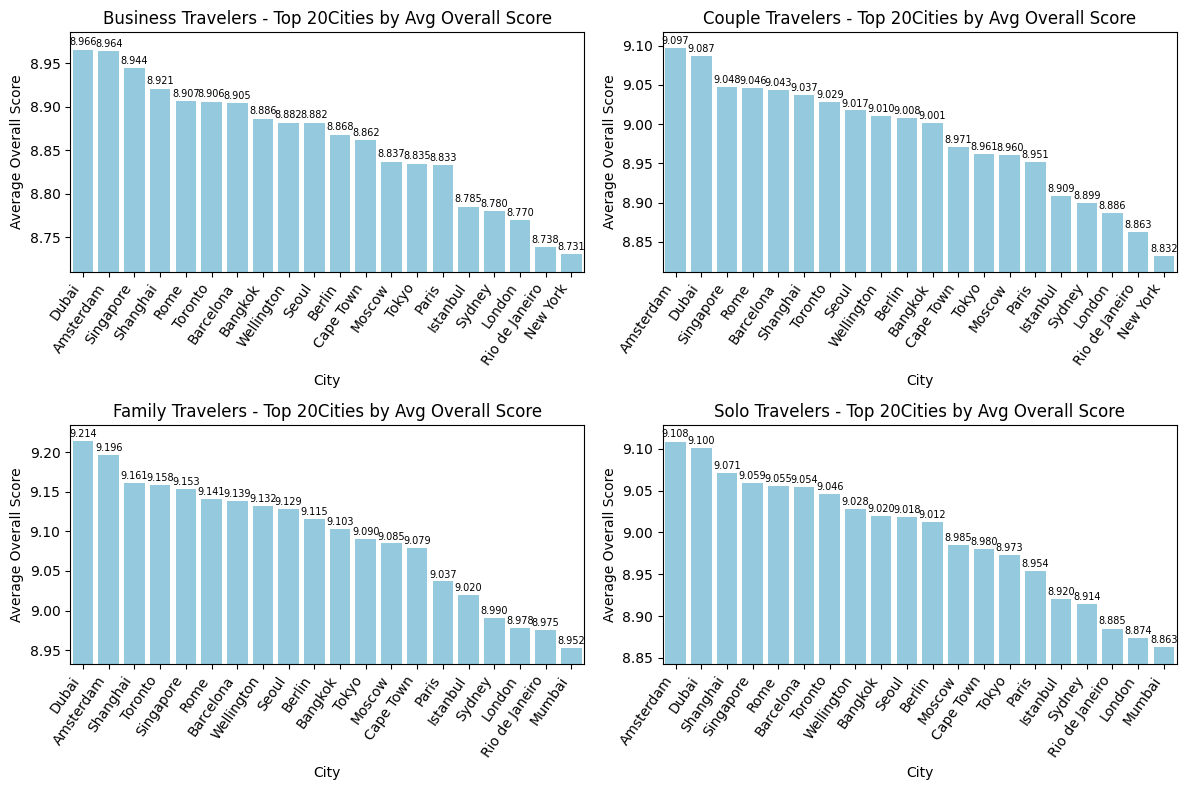

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
traveller_types = top_n_cities['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = top_n_cities[top_n_cities['traveller_type'] == ttype].sort_values('score_overall', ascending=False)
    
    # رسم الأعمدة بشكل رأسي
    sns.barplot(data=subset, x='city', y='score_overall', color='skyblue')
    
    # كتابة القيم فوق الأعمدة
    for index, value in enumerate(subset['score_overall']):
        plt.text(index, value + 0.005, f'{value:.3f}', ha='center', fontsize=7)
    
    plt.title(f'{ttype} Travelers - Top {n} Cities by Avg Overall Score')
    plt.xlabel('City')
    plt.ylabel('Average Overall Score')
    plt.ylim(subset['score_overall'].min() - 0.02, subset['score_overall'].max() + 0.02)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()


In [55]:
x = 10
top_x_countries = (
    grouped2_df
    .sort_values(['traveller_type', 'hotel_country'], ascending=[True, False])
    .groupby('traveller_type')
    .head(x)
)

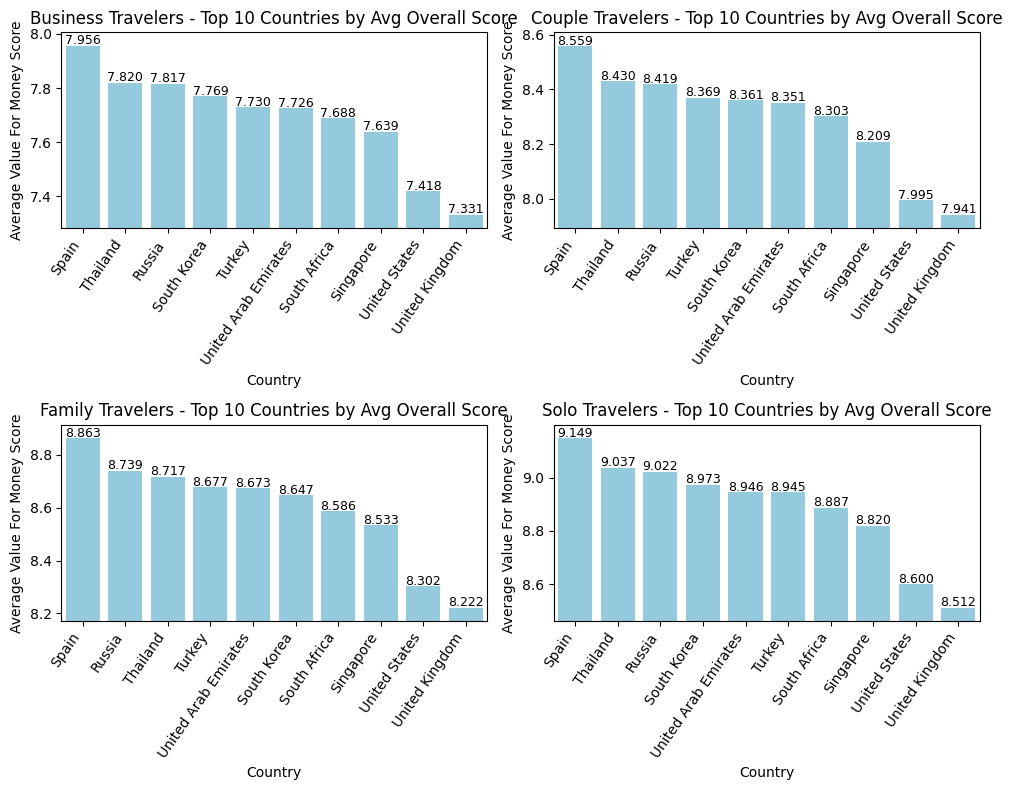

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
traveller_types = top_x_countries['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = top_x_countries[top_x_countries['traveller_type'] == ttype].sort_values('score_value_for_money', ascending=False)
    
    # رسم الأعمدة بشكل رأسي
    sns.barplot(data=subset, x='hotel_country', y='score_value_for_money', color='skyblue')
    
    # كتابة القيم فوق الأعمدة
    for index, value in enumerate(subset['score_value_for_money']):
        plt.text(index, value + 0.005, f'{value:.3f}', ha='center', fontsize=9)
    
    plt.title(f'{ttype} Travelers - Top {x} Countries by Avg Overall Score')
    plt.xlabel('Country')
    plt.ylabel('Average Value For Money Score')
    plt.ylim(subset['score_value_for_money'].min() - 0.05, subset['score_value_for_money'].max() + 0.05)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()


# Predictive Modeling Task

In [ ]:
    # one-hot encode categorical columns
    categorical_cols = ['traveller_type', 'age_group', 'city']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=np.uint8)

In [ ]:
X = df[['star_rating',
 'cleanliness_base', 'comfort_base', 'facilities_base',
 'location_base', 'staff_base', 'value_for_money_base',
 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities',
 'score_location', 'score_staff', 'score_value_for_money', 'user_gender',
 'traveller_type_Couple', 'traveller_type_Family', 'traveller_type_Solo',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'city_Bangkok', 'city_Barcelona', 'city_Berlin', 'city_Buenos Aires',
 'city_Cairo', 'city_Cape Town', 'city_Dubai', 'city_Istanbul', 'city_Lagos',
 'city_London', 'city_Mexico City', 'city_Moscow', 'city_Mumbai', 'city_New York',
 'city_Paris', 'city_Rio de Janeiro', 'city_Rome', 'city_Seoul', 'city_Shanghai',
 'city_Singapore', 'city_Sydney', 'city_Tokyo', 'city_Toronto', 'city_Wellington']]

y = df['country_group']

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical,
test_size=0.2, random_state=42)
print("\nLabel-encoded (numeric) y:")
print(y_encoded)

print("\nOne-hot encoded y (matrix):")
print(y_categorical)

In [ ]:
model = Sequential([Input(shape=(X_train.shape[1],)),
layers.Dense(128, activation='relu'),
layers.Dense(64, activation='relu'),
layers.Dense(y_train.shape[1], activation='softmax') 
])
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy',
Precision(name='precision'),
Recall(name='recall')])


In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Progress (Accuracy, Precision, Recall)')
plt.legend()
plt.show()


In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test,
y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


# Model Explainability

In [ ]:
import shap
shap.initjs()

import lime
import lime.lime_tabular

In [ ]:
background = shap.sample(X_train, 100, random_state=42)
explainer = shap.Explainer(model, background)
shap_values = explainer(X_test[0:100])


# Absolute Mean SHAP
This plot shows the contribution of each feature globally and ranks them

In [ ]:

class_names = label_encoder.classes_
print("Classes:", class_names)

for class_idx in range(11):
    # Extract SHAP values for this specific class
    shap_values_class = shap_values[:, :, class_idx]
    
    # Create bar plot for this class
    fig, ax = plt.subplots(figsize=(16, 6))  # new figure and axis
    shap.plots.bar(shap_values_class, show=False)
    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Waterfall Plot
This plot shows the contribution of each feature, moving it from the baseline value, to the prediction value

# Force Plot
This is a similar perspective, in a different format
from IPython.display import display

In [ ]:

observation = 0

# plt.rcParams['figure.figsize'] = (12, 6)  # default width/height for new figures


for class_idx in range(11):
    # Extract SHAP values for this specific class and observation
    shap_values_class_observation = shap_values[observation, :, class_idx]

    shap.plots.waterfall(shap_values_class_observation, max_display=5, show=False)

    fig = plt.gcf()   # get the current figure
    ax = plt.gca()    # get the current axes

    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel("Feature contribution to prediction")
    fig.suptitle("SHAP Waterfall Explanation", fontsize=16, fontweight="bold", y=1.03)
    plt.gcf().set_size_inches(16, 6)

    plt.tight_layout()
    plt.show()

    display(shap.plots.force(shap_values_class_observation))